In [6]:
import pandas as pd
import numpy as np
from model_function import Load_Model
import warnings
warnings.filterwarnings("ignore")

X_train_df = pd.DataFrame(Load_Model("X_train"), columns = Load_Model("features"))
X_test_df = pd.DataFrame(Load_Model("X_test"), columns = Load_Model("features"))
X_test = Load_Model("X_test")
y_test = Load_Model("y_test")
X_train = Load_Model("X_train")
y_train = Load_Model("y_train")
features = Load_Model("features")
model = Load_Model('xgb_model')

In [2]:
from pert_metrics import perturb
from featurelists import lime_list, shap_list

# Functions

In [3]:
# LIME  

from lime.lime_tabular import LimeTabularExplainer

# Global lime values

def LIME_global(X_train, X_test, features, model):
    explainer = LimeTabularExplainer(training_data=X_train, feature_names=features, class_names=y_train, verbose=True, mode='regression', discretize_continuous=False)
    lime_dict = {}
    for f in features:
        lime_dict[f] = []
    for i in range(len(X_test)):
        instance = X_test[i]
        explanation = explainer.explain_instance(instance, model.predict, num_features=len(features))
        explist = dict(explanation.as_list())
        for feature in explist.keys():
            # if feature not in lime_dict:
            #     lime_dict[feature] = []
            lime_dict[feature].append(explist[feature])
    lime_df = pd.DataFrame(lime_dict)
    return lime_df


In [12]:
def similar_perturbations(X, features, model, perturbation, sim_th, seed=None):

    X_df = pd.DataFrame(X, columns = features)
    X = np.array(X)
    #X_test_df = pd.DataFrame(X, columns = features)

    X_p = np.array(perturb(X_df,features, 0, perturbation , seed=seed))
    #X_test_p = np.array(perturb(X_test_df,features, 0, perturbation, seed=0))

    y_pred_p = model.predict(X)
    y_pred = model.predict(X_p)

    d = np.abs(y_pred_p - y_pred)
    # pd.DataFrame([y_pred, y_pred_p, y_pred_p - y_pred])

    idx_similar = np.where(d < sim_th*y_pred)[0]
    #print(idx_similar[:10])
    #idx_similar.shape

    X_p_similar = X_p[idx_similar]
    X_similar = X[idx_similar]

    return X_similar, X_p_similar

In [26]:
max_ratio = 0
p = 2  
ratiolist = []

def RIS_elementwise(X_sim, X_prime, exp, exp_prime, p, epsilon_min):
    # replace 0's with 0.0001 to avoid division by zero
    exp = np.where(exp == 0, 0.0001, np.array(exp))
    exp_prime = np.where(exp_prime == 0, 0.0001, np.array(exp_prime))
    X_sim = np.where(X_sim == 0, 0.0001, np.array(X_sim))
    X_prime = np.where(X_prime == 0, 0.0001, np.array(X_prime))

    
    ratiolist = []
    max_ratio = 0
    if len(X_sim) != len(X_prime) or len(exp) != len(exp_prime) or len(X_sim) != len(exp):
        raise ValueError("The length of the input data and the explanation data should be the same.")
    
    for i in range(len(X_prime)):     

        diff_ex =(exp[i] - exp_prime[i])/exp[i]
        #print(exp[i], exp_prime[i], diff_ex)
        numerator = np.linalg.norm(diff_ex, p)

        diff_input = (X_sim[i] - X_prime[i])/X_sim[i]
        denominator = max(np.linalg.norm(diff_input, ord=p), epsilon_min)

        ratio = numerator / denominator
        ratiolist.append(ratio)

    return ratiolist, np.mean(ratiolist)

In [39]:
max_ratio = 0
p = 2  
ratiolist = []

def RIS_norm(X_sim, X_prime, exp, exp_prime, p, epsilon_min):
    X_sim = np.array(X_sim)
    X_prime = np.array(X_prime)
    exp = np.array(exp)
    exp_prime = np.array(exp_prime)
    
    ratiolist = []
    max_ratio = 0
    if len(X_sim) != len(X_prime) or len(exp) != len(exp_prime) or len(X_sim) != len(exp):
        raise ValueError("The length of the input data and the explanation data should be the same.")
    
    for i in range(len(X_prime)):
        
        diff_ex = np.linalg.norm(exp[i] - exp_prime[i], p)
        numerator = diff_ex / np.linalg.norm(exp[i], p) 

        diff_input = np.linalg.norm(X_sim[i] - X_prime[i]) #/X_sim[i]
        denominator = max(diff_input / np.linalg.norm(X_sim[i], ord=p), epsilon_min)

        ratio = numerator / denominator
        ratiolist.append(ratio)

    return ratiolist, np.mean(ratiolist)

## Single RIS Values

## LIME

In [15]:
X_sim, X_sim_p = similar_perturbations(X_test, features, model, perturbation = 0.05, sim_th=0.01, seed=0)
lime_exp = LIME_global(X_train, X_sim, features, model)
lime_exp_p = LIME_global(X_train, X_sim_p, features, model)


Intercept 0.4375508599605484
Prediction_local [2.30060582]
Right: 0.7722644
Intercept 0.4163652920074913
Prediction_local [0.41472584]
Right: 0.12173709
Intercept 0.4138357094142912
Prediction_local [2.1840867]
Right: 1.7057182
Intercept 0.3932471400438443
Prediction_local [1.79407002]
Right: 2.8154812
Intercept 0.44461788547658876
Prediction_local [0.36793037]
Right: 0.01746045
Intercept 0.4654668270552259
Prediction_local [0.94662732]
Right: 0.11755557
Intercept 0.4401136775790314
Prediction_local [-0.11116347]
Right: 0.059326336
Intercept 0.44067553231130024
Prediction_local [1.07895981]
Right: 0.32243693
Intercept 0.45608425408009884
Prediction_local [0.05595857]
Right: 0.07523854
Intercept 0.4475788538876729
Prediction_local [0.27325337]
Right: 0.026629847
Intercept 0.41914313422922317
Prediction_local [0.68477246]
Right: 0.21821369
Intercept 0.48198944170948743
Prediction_local [-0.72446516]
Right: 0.007501701
Intercept 0.43993675052656095
Prediction_local [-0.12163579]
Right: 0.

In [27]:
p = 2 # euclidian norm
epsilon_min = 0.01 # minimum value of the denominator

print(RIS_elementwise(X_sim, X_sim_p, lime_exp, lime_exp_p, p, epsilon_min)[1])

46.02807283701819


## SHAP

In [18]:
import shap
X_train4shapely = pd.DataFrame(data=X_train, columns=features)
explainer = shap.Explainer(model, X_train4shapely)

In [19]:
shap_exp = explainer.shap_values(X_sim)
shap_exp_p = explainer.shap_values(X_sim_p)

In [28]:
epsilon_min = 0.1
p=2 # Euclidean norm
print(RIS_elementwise(X_sim, X_sim_p, shap_exp, shap_exp_p, p, epsilon_min)[1])

7.859055310643057


# Compare multiple similarity thresholds t

In [35]:
# RIS elementwise

lime_RIS2 = []
shap_RIS2 = []

epsilon_min = 0.1
for t in [i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]]:
    X_sim, X_sim_p = similar_perturbations(X_test, features, model, perturbation = 0.05, sim_th=t, seed=0)

    lime_exp = LIME_global(X_train, X_sim, features, model)
    lime_exp_p = LIME_global(X_train, X_sim_p, features, model)
    _, R = RIS_elementwise(X_sim, X_sim_p, lime_exp, lime_exp_p, 2, epsilon_min = epsilon_min)
    lime_RIS2.append(R)


    X_train4shapely = pd.DataFrame(data=X_train, columns=features)
    explainer = shap.Explainer(model, X_train4shapely)
    
    shap_values_1 = explainer.shap_values(X_sim)
    shap_values_2 = explainer.shap_values(X_sim_p)
    _, R = RIS_elementwise(X_sim, X_sim_p, shap_values_1, shap_values_2, 2, epsilon_min=epsilon_min)
    shap_RIS2.append(R)

Intercept 0.4520614412438037
Prediction_local [0.46058765]
Right: 0.01746045
Intercept 0.41514591516865557
Prediction_local [-0.01878741]
Right: 0.059326336
Intercept 0.4302823656108939
Prediction_local [0.11413209]
Right: 0.07523854
Intercept 0.4048139124455341
Prediction_local [0.09228332]
Right: 0.026629847
Intercept 0.4424337804197389
Prediction_local [0.84927951]
Right: 0.21821369
Intercept 0.4595145537970955
Prediction_local [-0.63488094]
Right: 0.007501701
Intercept 0.43655214193417036
Prediction_local [-0.14517737]
Right: 0.090647176
Intercept 0.44296481966258394
Prediction_local [0.85017943]
Right: 0.06402213
Intercept 0.45286414843807576
Prediction_local [2.16225975]
Right: 0.84840894
Intercept 0.4377134106471431
Prediction_local [1.62066671]
Right: 1.787522
Intercept 0.41254667324323546
Prediction_local [-0.17663705]
Right: 0.13285388
Intercept 0.48751675113563864
Prediction_local [-0.42390942]
Right: 0.033986073
Intercept 0.44135775467311217
Prediction_local [-0.25150156]
R

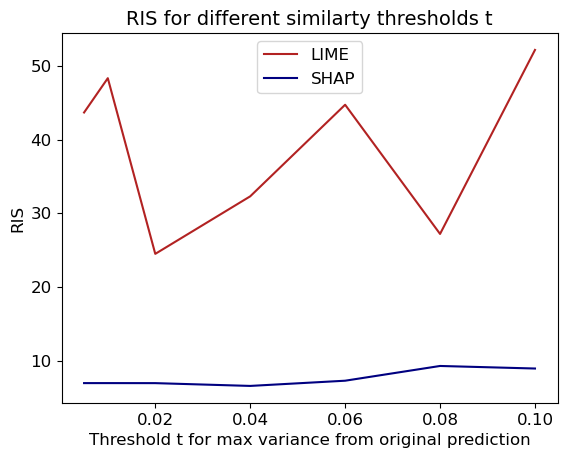

In [60]:
from matplotlib import pyplot as plt

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], lime_RIS2, label = "LIME", color = "firebrick")

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], shap_RIS2, label = "SHAP", color = "navy")
plt.title("RIS for different similarty thresholds t", fontsize = 14)
plt.xlabel("Threshold t for max variance from original prediction", fontsize = 12)
plt.ylabel("RIS", fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)

## RIS_norm

In [63]:
# RIS calculate percentage by norm division

lime_RIS3 = []
shap_RIS3 = []


for t in [i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]]:
    X_sim, X_sim_p = similar_perturbations(X_test, features, model, perturbation = 0.05, sim_th=t, seed=0)

    lime_exp = LIME_global(X_train, X_sim, features, model)
    lime_exp_p = LIME_global(X_train, X_sim_p, features, model)
    _, R = RIS_norm(X_sim, X_sim_p, lime_exp, lime_exp_p, 2, epsilon_min = 0.1)
    lime_RIS3.append(R)


    X_train4shapely = pd.DataFrame(data=X_train, columns=features)
    explainer = shap.Explainer(model, X_train4shapely)
    
    shap_values_1 = explainer.shap_values(X_sim)
    shap_values_2 = explainer.shap_values(X_sim_p)
    _, R = RIS_norm(X_sim, X_sim_p, shap_values_1, shap_values_2, 2, epsilon_min=0.1)
    shap_RIS3.append(R)

Intercept 0.4375508599605484
Prediction_local [2.30060582]
Right: 0.7722644
Intercept 0.4163652920074913
Prediction_local [0.41472584]
Right: 0.12173709
Intercept 0.41763605906627355
Prediction_local [1.9729033]
Right: 2.8154812
Intercept 0.40543653042558525
Prediction_local [0.47432954]
Right: 0.01746045
Intercept 0.4422917220422451
Prediction_local [0.74896969]
Right: 0.11755557
Intercept 0.4656857518252925
Prediction_local [0.03247893]
Right: 0.059326336
Intercept 0.43893734193432776
Prediction_local [1.02623176]
Right: 0.32243693
Intercept 0.4449335934887329
Prediction_local [0.19953009]
Right: 0.07523854
Intercept 0.45556597542930716
Prediction_local [0.22556459]
Right: 0.026629847
Intercept 0.4512680072039765
Prediction_local [0.80306472]
Right: 0.21821369
Intercept 0.40665570975069976
Prediction_local [-0.5986704]
Right: 0.007501701
Intercept 0.48974926589521006
Prediction_local [-0.18036407]
Right: 0.04310848
Intercept 0.4428523613947286
Prediction_local [0.4736882]
Right: 0.07

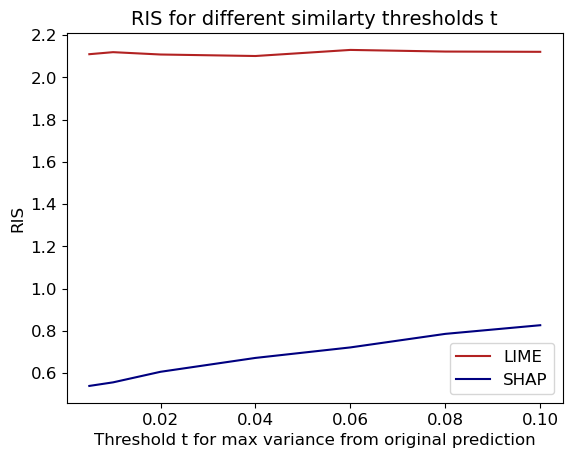

In [64]:
from matplotlib import pyplot as plt

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], lime_RIS3, label = "LIME", color = "firebrick")

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], shap_RIS3, label = "SHAP", color = "navy")
plt.title("RIS for different similarity thresholds t", fontsize = 14)
plt.xlabel("Threshold t for max. variance from original prediction", fontsize = 12)
plt.ylabel("RIS", fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)


## Previous definition

In [46]:
max_ratio = 0
p = 2  
ratiolist = []

def stability(X_sim, X_prime, exp, exp_prime, p):
    X_sim = np.array(X_sim)
    X_prime = np.array(X_prime)
    exp = np.array(exp)
    exp_prime = np.array(exp_prime)
    
    ratiolist = []
    
    if len(X_sim) != len(X_prime) or len(exp) != len(exp_prime) or len(X_sim) != len(exp):
        raise ValueError("The length of the input data and the explanation data should be the same.")
    
    for i in range(len(X_prime)):
        
        diff_ex = np.linalg.norm(exp[i] - exp_prime[i], p)

        diff_input = np.linalg.norm(X_sim[i] - X_prime[i]) 

        ratio = diff_ex / diff_input
        ratiolist.append(ratio)

    return ratiolist, np.mean(ratiolist)

In [65]:
lime_RIS4 = []
shap_RIS4 = []


for t in [i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]]:
    X_sim, X_sim_p = similar_perturbations(X_test, features, model, perturbation = 0.05, sim_th=t, seed=0)

    lime_exp = LIME_global(X_train, X_sim, features, model)
    lime_exp_p = LIME_global(X_train, X_sim_p, features, model)
    _, R = stability(X_sim, X_sim_p, lime_exp, lime_exp_p, 2)
    lime_RIS4.append(R)


    X_train4shapely = pd.DataFrame(data=X_train, columns=features)
    explainer = shap.Explainer(model, X_train4shapely)
    
    shap_values_1 = explainer.shap_values(X_sim)
    shap_values_2 = explainer.shap_values(X_sim_p)
    _, R = stability(X_sim, X_sim_p, shap_values_1, shap_values_2, 2)
    shap_RIS4.append(R)

Intercept 0.4375508599605484
Prediction_local [2.30060582]
Right: 0.7722644
Intercept 0.4163652920074913
Prediction_local [0.41472584]
Right: 0.12173709
Intercept 0.41763605906627355
Prediction_local [1.9729033]
Right: 2.8154812
Intercept 0.40543653042558525
Prediction_local [0.47432954]
Right: 0.01746045
Intercept 0.4422917220422451
Prediction_local [0.74896969]
Right: 0.11755557
Intercept 0.4656857518252925
Prediction_local [0.03247893]
Right: 0.059326336
Intercept 0.43893734193432776
Prediction_local [1.02623176]
Right: 0.32243693
Intercept 0.4449335934887329
Prediction_local [0.19953009]
Right: 0.07523854
Intercept 0.45556597542930716
Prediction_local [0.22556459]
Right: 0.026629847
Intercept 0.4512680072039765
Prediction_local [0.80306472]
Right: 0.21821369
Intercept 0.40665570975069976
Prediction_local [-0.5986704]
Right: 0.007501701
Intercept 0.48974926589521006
Prediction_local [-0.18036407]
Right: 0.04310848
Intercept 0.4428523613947286
Prediction_local [0.4736882]
Right: 0.07

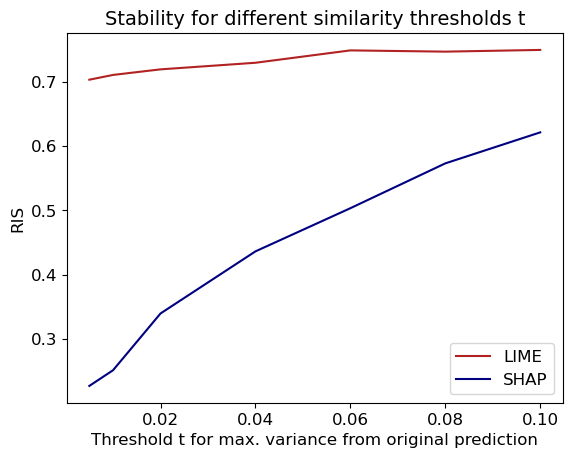

In [67]:
from matplotlib import pyplot as plt

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], lime_RIS4, label = "LIME", color = "firebrick")

plt.plot([i/100 for i in [0.5, 1, 2, 4, 6, 8, 10]], shap_RIS4, label = "SHAP", color = "navy")
plt.title("Stability for different similarity thresholds t", fontsize = 14)
plt.xlabel("Threshold t for max. variance from original prediction", fontsize = 12)
plt.ylabel("RIS", fontsize=12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)